In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip 'drive/My Drive/pucho/aerial cactus'

Archive:  drive/My Drive/pucho/aerial cactus.zip
  inflating: train.zip               
  inflating: train.csv               
  inflating: test.zip                
  inflating: sample_submission.csv   


In [0]:
!unzip 'train'

In [0]:
!unzip 'test'

In [0]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import imutils

Lets see a few images in the datatset.

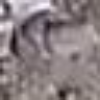

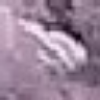

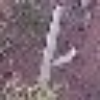

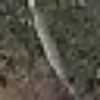

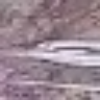

In [6]:
train_im=glob.glob('train/*.jpg')

count=0
for i in train_im:
  im=cv2.imread(i)
  im=cv2.resize(im,(100,100))
  cv2_imshow(im)
  
  count+=1
  if count==5:
    break

In [7]:
#Dataframe with image information
df=pd.read_csv('train.csv')
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.5+ KB


In [9]:
cactus=[]
cactus.append(sum(df['has_cactus']==0))
cactus.append(sum(df['has_cactus']==1))
cactus

[4364, 13136]

Lets visualise this unbalanced datatset.

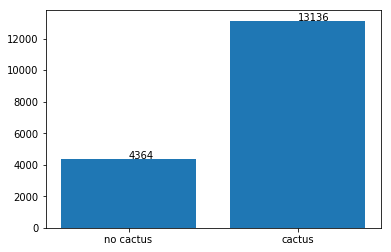

In [10]:
#an unbalanced dataset
import matplotlib.pyplot as plt
b1,b2=plt.bar(['no cactus','cactus'],[cactus[0],cactus[1]])
plt.text(1,13136,'13136')
plt.text(0,4364,'4364')
plt.axis(right=False);

Augmenting the dataset

In [0]:
#save array values of image in list
x=[]
y_ans=[]

#open images with glob
train_im=glob.glob('train/*.jpg')


for name in train_im:

  im=cv2.imread(name)
  
  #blur
  
  #im=cv2.blur(im,(3,3))
  #im=cv2.blur(im,(5,5))
  #im=cv2.bilateralFilter(im,5,13,13)
  
  #sharpening
  
  #blur=ndimage.gaussian_filter(im,sigma=3)
  #filter=ndimage.gaussian_filter(blur,1)
  #alpha=30
  #im=blur+alpha*(blur-filter)
  
  
  x.append(im)
  y_ans.append(df[df['id']==name.split('/')[1]]['has_cactus'].values[0])
  
  #flip left/right
  x.append(np.fliplr(im))
  y_ans.append(df[df['id']==name.split('/')[1]]['has_cactus'].values[0])
  
  #flip up/down
  x.append(np.flipud(im))
  y_ans.append(df[df['id']==name.split('/')[1]]['has_cactus'].values[0])
  
  #rotate 90 degree
  x.append(np.rot90(im))
  y_ans.append(df[df['id']==name.split('/')[1]]['has_cactus'].values[0])
  
  

Normalize images between [0,1]

In [12]:
x=np.asarray(x)
x=x/255
x.shape

(70000, 32, 32, 3)

In [13]:
y_ans=np.asarray(y_ans)
y_ans.shape

(70000,)

In [0]:
#preparing test file images
test=[]

#open images with glob
test_im=glob.glob('test/*.jpg')


for name in test_im:

  im=cv2.imread(name)
  
  test.append(im)
  

A little preprocessing never hurt anyone.

In [15]:
test=np.asarray(test)
test=test/255
test.shape

(4000, 32, 32, 3)

# Neural net

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


##cnn

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y_ans,test_size=0.3,random_state=27)

In [0]:
# #augmenting data
# from keras.preprocessing.image import ImageDataGenerator
# datagen=ImageDataGenerator(rotation_range=90,
#                           horizontal_flip=True,
#                           vertical_flip=True,
#                           validation_split=0.3)
# datagen.fit(X_train)

In [0]:
nn=Sequential()

nn.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(32, 32, 3)))
nn.add(MaxPooling2D(pool_size=2))
nn.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
nn.add(MaxPooling2D(pool_size=2))
nn.add(Conv2D(filters=64, kernel_size=6, padding='same', activation='relu'))
nn.add(MaxPooling2D(pool_size=2))

nn.add(Dropout(0.3))
nn.add(Flatten())
nn.add(Dense(500, activation='relu'))
nn.add(Dropout(0.3))
nn.add(Dense(1, activation='sigmoid'))

In [0]:
checkpoint=ModelCheckpoint(filepath='ann.best.hdf5',verbose=1,save_best_only=True)
es=EarlyStopping(monitor='val_loss',verbose=1,mode='min')

In [0]:
nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
history=nn.fit(X_train,y_train,verbose=1,validation_split=0.3,batch_size=100,callbacks=[es,checkpoint],epochs=10)
#history=nn.fit_generator(datagen.flow(X_train,y_train,batch_size=100),epochs=10,callbacks=[checkpoint,es],validation_data=(X_test,y_test),
#                        verbose=1,steps_per_epoch=len(X_train)/100)

Train on 34300 samples, validate on 14700 samples
Epoch 1/10
34300/34300 [==============================] - 4s 110us/step - loss: 0.1676 - acc: 0.9332 - val_loss: 0.1028 - val_acc: 0.9620

Epoch 00001: val_loss improved from inf to 0.10278, saving model to ann.best.hdf5
Epoch 2/10
34300/34300 [==============================] - 3s 89us/step - loss: 0.0902 - acc: 0.9663 - val_loss: 0.0792 - val_acc: 0.9722

Epoch 00002: val_loss improved from 0.10278 to 0.07924, saving model to ann.best.hdf5
Epoch 3/10
34300/34300 [==============================] - 3s 91us/step - loss: 0.0763 - acc: 0.9722 - val_loss: 0.1324 - val_acc: 0.9496

Epoch 00003: val_loss did not improve from 0.07924
Epoch 00003: early stopping


In [0]:
nn.evaluate(X_test,y_test)

21000/21000 [==============================] - 2s 82us/step


[0.12622078043399823, 0.9509047619047619]

## vgg16

In [0]:
from keras.applications import VGG16

In [18]:
from keras import optimizers
Adam=optimizers.adam(lr=0.0001)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
vgg=VGG16(include_top=False,input_shape=(32,32,3))

#make vgg layers untrainable
for layer in vgg.layers:
  layer.trainable=False
  
#add vgg layers to our sequential model  
model=Sequential()
for layer in vgg.layers:
  model.add(layer)  

#add a few more layers 
model.add(Flatten())
model.add(Dense(250))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(BatchNormalization())

#add the last layer
model.add(Dense(1,activation='sigmoid'))

#compile the model
model.compile(loss='binary_crossentropy',optimizer=Adam,metrics=['accuracy'])


58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y_ans,test_size=0.2,random_state=6)

In [0]:
checkpoint=ModelCheckpoint(filepath='vgg.best.hdf5',verbose=1,save_best_only=True)
es=EarlyStopping(monitor='val_acc',verbose=1,mode='max')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         295168    
__________

In [23]:
history=model.fit(X_train,y_train,verbose=1,validation_split=0.1,callbacks=[checkpoint,es],batch_size=50,epochs=20)

Instructions for updating:
Use tf.cast instead.
Train on 50400 samples, validate on 5600 samples
Epoch 1/20
50400/50400 [==============================] - 20s 390us/step - loss: 0.2644 - acc: 0.9026 - val_loss: 0.1232 - val_acc: 0.9589

Epoch 00001: val_loss improved from inf to 0.12325, saving model to vgg.best.hdf5
Epoch 2/20
50400/50400 [==============================] - 15s 301us/step - loss: 0.1310 - acc: 0.9588 - val_loss: 0.1007 - val_acc: 0.9666

Epoch 00002: val_loss improved from 0.12325 to 0.10068, saving model to vgg.best.hdf5
Epoch 3/20
50400/50400 [==============================] - 15s 301us/step - loss: 0.1049 - acc: 0.9641 - val_loss: 0.0822 - val_acc: 0.9684

Epoch 00003: val_loss improved from 0.10068 to 0.08220, saving model to vgg.best.hdf5
Epoch 4/20
50400/50400 [==============================] - 15s 304us/step - loss: 0.0937 - acc: 0.9669 - val_loss: 0.0744 - val_acc: 0.9721

Epoch 00004: val_loss improved from 0.08220 to 0.07441, saving model to vgg.best.hdf5
Epo

In [24]:
model.evaluate(X_test,y_test)

14000/14000 [==============================] - 4s 308us/step


[0.06663644795492292, 0.9737142857142858]

In [0]:
model.save('drive/My Drive/pucho/vgg.best.hdf5')

In [28]:
model.load_weights('drive/My Drive/pucho/vgg.best.hdf5')
#evaluate on test data
model.evaluate(X_test,y_test,verbose=1)

14000/14000 [==============================] - 4s 282us/step


[0.06663644795492292, 0.9737142857142858]

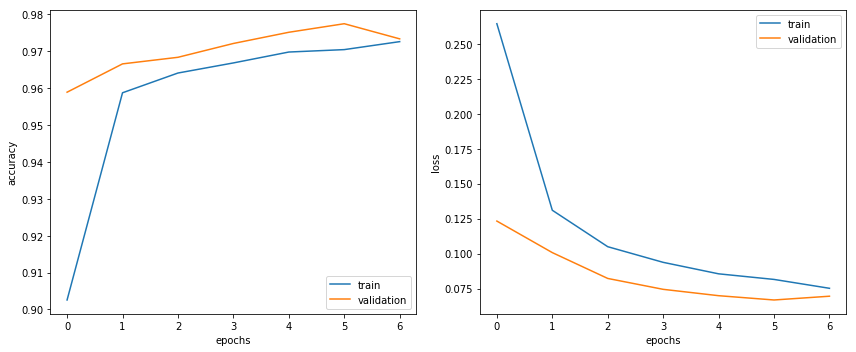

In [47]:
fig,axes=plt.subplots(1,2,figsize=(12,5))

#plot accuracy
axes[0].plot(history.history['acc'],label='train')
axes[0].plot(history.history['val_acc'],label='validation')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend(loc=4);
#plot loss
axes[1].plot(history.history['loss'],label='train')
axes[1].plot(history.history['val_loss'],label='validation')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epochs')
axes[1].legend(loc=1);

fig.tight_layout();

Classification report for seperated test dataset.

In [48]:
from sklearn.metrics import classification_report

predict=model.predict_classes(X_test)
print(classification_report(y_test,predict,target_names=['no cactus','cactus']))

              precision    recall  f1-score   support

   no cactus       0.98      0.92      0.95      3479
      cactus       0.97      0.99      0.98     10521

    accuracy                           0.97     14000
   macro avg       0.97      0.95      0.96     14000
weighted avg       0.97      0.97      0.97     14000



Predicting cactus image with 98% accuracy.

Good f1-score.

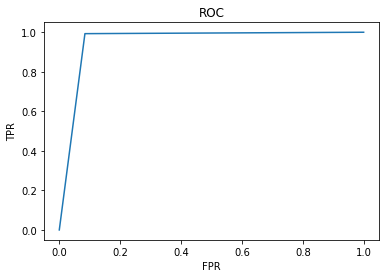

In [49]:
from sklearn.metrics import precision_recall_curve,roc_curve

fpr,tpr,_=roc_curve(y_test,predict)

plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC');

Good AUC.

In [0]:
model.load_weights('drive/My Drive/pucho/vgg.best.hdf5')
predict=model.predict(test)

In [0]:
submit=pd.DataFrame(columns=['id','has_cactus'])

In [0]:
#open images with glob
test_im=glob.glob('test/*.jpg')

index=0
for name in test_im:

  name=name.split('/')[1]
  
  submit.loc[index,'id']=name
  submit.loc[index,'has_cactus']=predict[index]
  index+=1
  

In [0]:
submit.to_csv('drive/My Drive/pucho/submit.csv',index=False)